## RC Demo WheatFspm

The goal of this notebook is to devise a suitable **train-test split** for the WheatFspm NEMA simulations as well as apply a **grouping strategy** for the cross-validation folds.

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

In [2]:
DATASET_NEMA_H0 = '../datasets/dataset_NEMA_NEMA_H0.csv'
DATASET_NEMA_H3 = '../datasets/dataset_NEMA_NEMA_H3.csv'
DATASET_NEMA_H15 = '../datasets/dataset_NEMA_NEMA_H15.csv'

## Loading the dataset

These datasets were collected and converted in the WheatFspm repository.

In [5]:
from src.model.rc_dataset import ExperimentDataset

dataset_nema_h0 = ExperimentDataset(csv_path=DATASET_NEMA_H0)
dataset_nema_h3 = ExperimentDataset(csv_path=DATASET_NEMA_H3)
dataset_nema_h15 = ExperimentDataset(csv_path=DATASET_NEMA_H15)

## Defining targets and observable state variables

These were selected in the previous notebook, `2022_03_23_wheatfspm_dataset_inspection.ipynb`

In [12]:
hydroshoot_inputs = (
  'input_air_temperature', 
  'input_humidity',
  'input_Wind',
  'input_PARi'
)

hydroshoot_outputs = (
  'output__axes__Total_Transpiration',
  'output__axes__C_exudated', 
  'output__axes__SAM_temperature'
)

hydroshoot_state = (
  'state__An',
  'state__Transpiration',
  'state__S_Sucrose',
  'state__Ts',
  'state__gs'
)

exclusive_outputs = (
  'output__axes__delta_teq',
  'output__axes__sum_respi_shoot',
  'output__organ_roots__N_exudation'
)

exclusive_state = (
  'state__Ag',
  'state__Tr',
  'state__sucrose',
  'state__Rd',
  'state__sum_respi',
  'state__Photosynthesis',
  'state__PARa'
)


input_targets = [*hydroshoot_inputs]
output_targets = [*hydroshoot_outputs, *exclusive_outputs]


targets = [*input_targets, *output_targets]
state_variables = [*hydroshoot_state, *exclusive_state]




print(f'Targets:')
for target in targets:
  print(f'\t- {target}')

print(f'\nState variables:')
for state_var in state_variables:
  print(f'\t- {state_var}')

Targets:
	- input_air_temperature
	- input_humidity
	- input_Wind
	- input_PARi
	- output__axes__Total_Transpiration
	- output__axes__C_exudated
	- output__axes__SAM_temperature
	- output__axes__delta_teq
	- output__axes__sum_respi_shoot
	- output__organ_roots__N_exudation

State variables:
	- state__An
	- state__Transpiration
	- state__S_Sucrose
	- state__Ts
	- state__gs
	- state__Ag
	- state__Tr
	- state__sucrose
	- state__Rd
	- state__sum_respi
	- state__Photosynthesis
	- state__PARa


The target data can be generated in the same way as the code used for HydroShoot:

In [106]:
# There is an apparent regime change after some time step (see daily notes 2022-03-25).
# To enforce pseudo-stationarity of the reservoir dynamics we will limit the used data
# to the simulation steps before the regime change.

max_time_step = {
  'NEMA_H0': 696,
  'NEMA_H3': 864,
  'NEMA_H15': 912
}

In [107]:
def direct_target_generator(dataset: ExperimentDataset, target: str, run_id):
    """Returns a generator that generates the target from the run id."""
    assert target in dataset.get_targets(), f"{target} not available in dataset."

    yield dataset.get_target(target, run_id).to_numpy()[:max_time_step[run_id]]


target_gen = direct_target_generator(dataset_nema_h3, targets[0], 'NEMA_H3')

print(next(target_gen).shape)

(864,)


Not every observed node has a value for the given state variable (e.g. difference between stem vs leaf).

To generate the reservoir time series, we need to filter out the NaN states.

In [109]:
def direct_reservoir_generator(dataset: ExperimentDataset, state_var: str, run_id):
    """Returns a function that generates the reservoir from the run id."""
    assert (
        state_var in dataset.get_state_variables()
    ), f"{state_var} not available in dataset."

    state = dataset.get_state(state_var, run_id)[:max_time_step[run_id]]

    state_NaN = np.isnan(state)
    state_col_idx = np.all(state_NaN, axis=0)
    state = state[:, ~state_col_idx]

    yield state


state_gen = direct_reservoir_generator(dataset_nema_h3, state_variables[0], 'NEMA_H3')
print(next(state_gen).shape)

(864, 10)


## Data preprocessing

Preprocessing performed:

1. ~~A random subsample of observation nodes is selected.~~ for now, no subsampling (the state is already small!)
2. The target signal for each run is computed.
3. Target and reservoir are cast into a ndarray.
4. Target and reservoir signals are trimmed.
   - A warmup mask is applied to target and reservoir.
   - A night-time mask is applied to target and reservoir.
5. Target and reservoir are rescaled to zero-mean and unit variance
   - Normalizing transform is fitted on the entire dataset of included experiment runs.

In [110]:
def preprocess_data(dataset, target, reservoir, warmup_steps=0, day_mask=None):
  
  # 2. Cast target and reservoir state into NumPy ndarrays.
  # first dimension is run_id, for compatibility with HydroShoot code
  X = np.empty((1, *reservoir.shape))  # shape (n_runs, time_steps, nodes)
  y = np.empty((1, *target.shape))     # shape (n_runs, time_steps)
  
  X[0, :, :] = reservoir
  y[0, :] = target

  # 3. Masks are applied.
  if day_mask is None: 
    time_mask = np.ones(X.shape[1], dtype=bool)
  else:
    n_days = X.shape[1] // len(day_mask)
    assert dataset.n_steps() % len(day_mask) == 0, "Dataset time steps must be multiple of day mask."
    time_mask = np.tile(day_mask, n_days) 
  
  time_mask[:warmup_steps] = False
  X = X[:, time_mask, :]
  y = y[:, time_mask]

  # 4. Normalize target and reservoir states
  X = (X - X.mean()) / X.std()
  y = (y - y.mean()) / y.std()

  return X, y

In [118]:
from src.learning.preprocessing import generate_mask


DATASET = dataset_nema_h3
RUN_ID = 'NEMA_H3'

TARGET = targets[0]
STATE_VAR = state_variables[0]

WARMUP_STEPS = 4 * 24
DAY_MASK = generate_mask(5, 21)


target = next(direct_target_generator(DATASET, TARGET, RUN_ID))
reservoir = next(direct_reservoir_generator(DATASET, STATE_VAR, RUN_ID))
X_raw, y_raw = preprocess_data(DATASET, target, reservoir, WARMUP_STEPS, DAY_MASK)

print(X_raw.shape)
print(y_raw.shape)        

(1, 512, 10)
(1, 512)


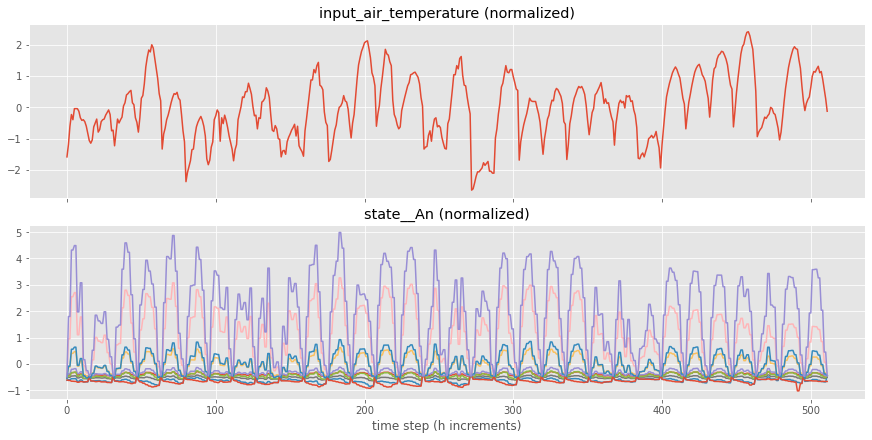

In [119]:
with plt.style.context('ggplot'):
  fig, (ax_target, ax_reservoir) = plt.subplots(2, 1, figsize=(12, 6), constrained_layout=True, sharex=True)

  ax_target.plot(y_raw[0, :])
  ax_target.set_title(f'{TARGET} (normalized)')

  ax_reservoir.plot(X_raw[0, :, :])
  ax_reservoir.set_title(f'{STATE_VAR} (normalized)')
  ax_reservoir.set_xlabel('time step (h increments)')

  plt.show()

## Grouping

Grouping will be done on a calendar day basis. This is simpler than with the HydroShoot dataset because it is a single stream of data rather than multiple overlapping runs.

```
GROUP 1 | GROUP 2 | GROUP 3 | GROUP 4 | ...
--------+---------+---------+---------+----
sim/d1   sim/d2    sim/d3    sim/d4     ...
```

In [121]:
X = X_raw[0, :, :]
y = y_raw[0, :]

print(X.shape)
print(y.shape)        

(512, 10)
(512,)


In [126]:
def group_by_day(X: np.ndarray, day_mask: np.ndarray) -> np.ndarray:
  day_length = day_mask.sum()
  assert len(X) % day_length == 0, "X must have multiple of day_mask time steps."

  n_groups = len(X) // day_length

  groups = np.arange(n_groups).repeat(day_length)
  return groups

In [127]:
X = X_raw[0, :, :]
y = y_raw[0, :]
groups = group_by_day(X, DAY_MASK)

print(X.shape)
print(y.shape)     
print(groups.shape)     

(512, 10)
(512,)
(512,)
